<a href="https://colab.research.google.com/github/wisemanam/NIHLungNet/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Lung Disease Using CNNs

In [2]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
import pandas as pd
import keras
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

     |████████████████████████████████| 706kB 12.9MB/s 


## Loading in the Data

In [3]:
data_path = '/content/drive/MyDrive/data/xray_data/'
train_path = data_path + 'train/'
test_path = data_path + 'test/'

In [4]:
df = pd.read_csv(data_path + "Data_Entry_2017.csv")
df["Finding Labels"]=df["Finding Labels"].apply(lambda x:x.split(","))
classes = ["No Finding", 
           "Atelectasis", 
           "Consolidation", 
           "Infiltration",
           "Pneumothorax",
           "Edema",
           "Emphysema",
           "Fibrosis",
           "Effusion",
           "Pneumonia",
           "Pleural_Thickening",
           "Cardiomegaly",
           "Mass",
           "Nodule",
           "Hernia"]

datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

# using 15000/86524 training images
train_it=datagen.flow_from_dataframe(dataframe=df, 
                                            directory=train_path, 
                                            x_col="Image Index", 
                                            y_col="Finding Labels", 
                                            batch_size=32, 
                                            seed=42, 
                                            shuffle=True, 
                                            class_mode="categorical",
                                            classes=classes,
                                            target_size=(1024,1024))

# using 2000/~20000 testing images
test_it=test_datagen.flow_from_dataframe(dataframe=df,
                                                directory=test_path,
                                                x_col="Image Index",
                                                y_col="Finding Labels",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode="categorical",
                                                classes=classes,
                                                target_size=(1024,1024))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 89061 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 20075 validated image filenames belonging to 15 classes.
Found 2340 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 108910 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Creating the Model
Next, I am going to create the model that will train on the Chest X-Rays. I am going to start with a pre-trained network and see if that helps training go more smoothly. I am using categorical crossentropy as my loss function to allow for multiple labels being present. I also use sigmoid activation to accommodate multiple labels. 

In [5]:
# load model without classifier layers
model = DenseNet121(include_top=False, input_shape=(1024, 1024, 3), weights='imagenet', pooling='max')

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='sigmoid')(flat1)
dropout = Dropout(0.2)
output = Dense(15, activation='sigmoid')(class1)

# define new model
model = Model(inputs=model.inputs, outputs=output)

for layer in model.layers[:-4]:
    layer.trainable=False

optimizer = keras.optimizers.Adam(lr=0.00001)
model.compile(loss=[tfa.losses.SigmoidFocalCrossEntropy(gamma=4.0)], metrics=["accuracy"], optimizer=optimizer)
history = model.fit(train_it, batch_size=256, epochs=20, validation_data=test_it)

# optimizer = keras.optimizers.Adam(lr=0.001)
# model.compile(loss=[tfa.losses.SigmoidFocalCrossEntropy(gamma=4.0)], metrics=["accuracy"], optimizer=optimizer)
# history2 = model.fit(train_it, batch_size=256, epochs=20, validation_data=test_it)

# optimizer = keras.optimizers.Adam(lr=0.0005)
# model.compile(loss=[tfa.losses.SigmoidFocalCrossEntropy(gamma=4.0)], metrics=["accuracy"], optimizer=optimizer)
# history3 = model.fit(train_it, batch_size=256, epochs=20, validation_data=test_it)


29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/20
628/628 [==============================] - 12313s 20s/step - loss: 0.2021 - accuracy: 0.5328 - val_loss: 0.0889 - val_accuracy: 0.5026
Epoch 2/20
628/628 [==============================] - 845s 1s/step - loss: 0.0607 - accuracy: 0.7090 - val_loss: 0.0852 - val_accuracy: 0.4979
Epoch 3/20
628/628 [==============================] - 836s 1s/step - loss: 0.0584 - accuracy: 0.7136 - val_loss: 0.0842 - val_accuracy: 0.5030
Epoch 4/20
628/628 [==============================] - 831s 1s/step - loss: 0.0572 - accuracy: 0.7093 - val_loss: 0.0822 - val_accuracy: 0.5043
Epoch 5/20
628/628 [==============================] - 827s 1s/step - loss: 0.0556 - accuracy: 0.7145 - val_loss: 0.0827 - val_accuracy: 0.5073
Epoch 6/20
628/628 [==============================] - 825s 1s/step - loss: 0.0545 - accuracy: 0.7195 - val_loss: 0.0794 - val_accuracy: 0.5017
Epoch 7/20
628/628 [==============================] - 841s 1s/step - loss:

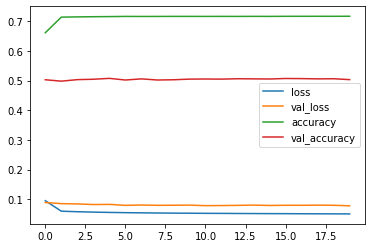

In [6]:
plt.plot( history.epoch,history.history['loss'], label = 'loss' )
plt.plot( history.epoch,history.history['val_loss'], label = 'val_loss' )
plt.legend()

plt.plot( history.epoch,history.history['accuracy'], label = 'accuracy' )
plt.plot( history.epoch,history.history['val_accuracy'], label = 'val_accuracy' )
plt.legend()

In [7]:
model.evaluate(test_it)

2340/2340 [==============================] - 101s 43ms/step - loss: 0.0779 - accuracy: 0.5030


[0.07793980836868286, 0.5029914379119873]